In [12]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget
#%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib.container import BarContainer
plt.style.use('seaborn-notebook')
import numpy as np
import pandas as pd
from IPython.display import display, clear_output
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from ipywidgets import interact, interact_manual, Layout
import mplcursors

from mysql_collect_test import connect_config
from driver.collector.collector_factory import get_collector
from driver.collector.mysql_collector import MysqlCollector

import warnings
warnings.filterwarnings('ignore')

In [16]:
from query_library import get_query_library

ql = get_query_library()

In [62]:
# QUERY_EXAMPLE = """SELECT (100 * SUM_TIMER_WAIT / sum(SUM_TIMER_WAIT) OVER ()) percent, 
#         sum_timer_wait as total, 
#         count_star as calls, 
#         avg_timer_wait as mean,
#         substring(digest_text,1,75)
# FROM 
# performance_schema.events_statements_summary_by_digest 
#         ORDER BY sum_timer_wait DESC
#         LIMIT 5;"""
config = connect_config()

def q(query):
    with get_collector(config) as collector:
       # print(collector._cmd(query))  # 0 data 1 meta
       
        df = pd.read_sql(query, con=collector.get_conn())
        from IPython.core.display import HTML
        display(HTML(df.to_html()))
    col_list = list(df.columns)
    if len(df) == 0:
        print("EMPTY DF")
        return df
        
    for i,val in enumerate(df.iloc[0]): # unit removal
        val = str(val)
        if ' ps' in val:
            col_list[i] += ' (ps)'
            val.replace(' ps','')
            df.iloc[:,i] = df.iloc[:,i].str.replace(r'\s|[a-z]', '')
            df.iloc[:,i] = pd.to_numeric(df.iloc[:,i])
        if ' us' in val:
            col_list[i] += ' (us)'
            val.replace(' us','')
            df.iloc[:,i] = df.iloc[:,i].str.replace(r'\s|[a-z]', '')
            df.iloc[:,i] = pd.to_numeric(df.iloc[:,i])
        if ' ms' in val:
            col_list[i] += ' (ms)'
            val.replace(' ms','')
            df.iloc[:,i] = df.iloc[:,i].str.replace(r'\s|[a-z]', '')
            df.iloc[:,i] = pd.to_numeric(df.iloc[:,i])
    df.columns = col_list
    #display(df)
#     df_numerics_only = df.select_dtypes(include=np.number)
#     display(df_numerics_only)
    #print(df.columns)
    if len(df) == 0:
        print("No Record")
    
    x_list = []
    for i in df.columns:
        if 'query' in i:
            x_list.append(i)
            continue
        if 'digest' in i:
            x_list.append(i)
            continue
        if 'text' in i:
            x_list.append(i)
            continue
    
    y_list = list(df.columns)
    for i in x_list:
        y_list.remove(i)
        
    df_numerics_only = df.select_dtypes(include=np.number)
    #display(df_numerics_only)
            
    
    if len(df_numerics_only.columns) == 0:
        print("No numerical attributes to plot")
        
        w2 = widgets.Select(options=df.columns, disabled=False)
        box2 = widgets.Box([
            widgets.Label(value='Select attribute to plot:'),
            w2
        ])


        button2 = widgets.Button(description='Draw', color = 'blue',)
        
        reset_button = widgets.Button(description='Clear output', color = 'green',)
        def reset_on_click_callback(clicked_button: widgets.Button) -> None:
            clear_output()
            display(box)
            display(button)
        reset_button.on_click(reset_on_click_callback)
        
        def on_click_callback2(clicked_button: widgets.Button) -> None:
            #print(w.value)
            #print(x_list)
            plt.rcParams["figure.figsize"] = [9, 5]
            fig, ax = plt.subplots()
            
            ax = df[w2.value].value_counts().plot(kind='bar',
                                    title=f"Frequency of {w2.value}")
            plt.yticks(fontsize=10)
            plt.xticks(fontsize=10, rotation = 0)
            
            crs = mplcursors.cursor(ax)
            display(reset_button)
        button2.on_click(on_click_callback2)
        #

        display(box2)
        display(button2)
        
        
    else:
        w = widgets.SelectMultiple(options=df_numerics_only.columns, disabled=False)
        box = widgets.Box([
            widgets.Label(value='Select attributes to plot:'),
            w
        ])
        
        reset_button = widgets.Button(description='Clear output', color = 'green',)
        def reset_on_click_callback(clicked_button: widgets.Button) -> None:
            clear_output()
            display(box)
            display(button)
        reset_button.on_click(reset_on_click_callback)

        button = widgets.Button(description='Draw', color = 'blue',)
        
        def on_click_callback(clicked_button: widgets.Button) -> None:
            #print(w.value)
            #print(x_list)
            plt.rcParams["figure.figsize"] = [9, 5]
            fig, ax = plt.subplots()
            if len(x_list) != 0:

                x = list(df[x_list[0]])
        #         def split_text(string):
        #             words = string.split()
        #             grouped_words = [' '.join(words[i: i + 5]) for i in range(0, len(words), 5)]
        #             newline_words = '\n'.join(grouped_words)
        #             return newline_words

        #         x = [split_text(i) for i in x]
                df_plot = df[list(w.value)]
                df_plot.plot(kind='bar', ax = ax, title = f"{', '.join(list(w.value))} by query")

                plt.yticks(fontsize=10)
                plt.xticks(fontsize=10, rotation = 0)
                #ax.set_yscale('log')


                #mplcursors.cursor(hover=True)
                def cursor_annotations(sel):
                    bar = sel.artist[sel.target.index]
                    sel.annotation.set(fontsize=10, text=f'content:{sel.artist.get_label()}\nindex: {sel.target.index}\nquery: {x[sel.target.index]}\nvalue: {df[sel.artist.get_label()][sel.target.index]}', position=[0, 10], anncoords="offset points")
                    if sel.target.index > (len(x)-1) / 2:
                        sel.annotation.set(position=[-10, 10])
                    elif sel.target.index < (len(x)-1) / 2:
                        sel.annotation.set(position=[10, 10])
                    else:
                        sel.annotation.set(position=[0, 10])
                    sel.annotation.xy = (bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2)
                    sel.annotation.get_bbox_patch().set_alpha(0.8)

                crs = mplcursors.cursor(ax)
                crs.connect("add", cursor_annotations)
                #lambda sel: sel.annotation.set_text(sel.artist.get_label()))# sel.annotation.set_text(f'index: {sel.artist.get_label()}\nquery: {df[y][sel.artist.get_label()]}\nvalue: {bar.get_height():.1f}'))
                #cursor.connect('add', show_annotation)
                #ax.legend()
                ax.set_xlabel('Query Index')
                ax.set_ylabel('Value')
                #ax.set_suptitle(f"{','.join(list(w.value))} by query")
                plt.tight_layout()
                plt.show()
                display(reset_button)
                
                
                
            else:
                print('Not implemented')


        button.on_click(on_click_callback)
        #

        display(box)
        display(button)

    return df

# df = q(QUERY_EXAMPLE)


#     y = list(df.columns).remove('query')
#     print(y)

#checkboxes = [widgets.Checkbox(value=False, description=label) for label in df.columns]
#output = widgets.VBox(children=checkboxes)
#display(output)

In [63]:
def get_query_template():
    style = {'description_width': '200px'}
    layout = {'width': '400px'}
    category_widget = widgets.Dropdown(description='Select category of query:', 
                                       options = list(ql.keys()), 
                                       layout=layout, 
                                       style = style)
    query_widget = widgets.Dropdown(description='Select query to execute:', 
                                    layout=layout, 
                                    style = style)

    button = widgets.Button(description='Go!', color = 'blue',)
    # Define a function that updates the content of y based on what we select for x
    def update(*args):
        query_widget.options = list(ql[category_widget.value].keys())
    category_widget.observe(update)


    button2 = widgets.Button(description='Execute', color = 'blue',)

    def on_click_callback(clicked_button: widgets.Button) -> None:
    #
        clear_output()
        display(box)
        print(f" Query Template for {query_widget.value.replace('_',' ')} ")
        print(f"===============================================")
        print(ql[category_widget.value][query_widget.value])

        print(f"===============================================")

        display(button2) # Execute


    def on_click_callback2(clicked_button: widgets.Button) -> None:
        q(ql[category_widget.value][query_widget.value])
        

    button2.on_click(on_click_callback2)

    button.on_click(on_click_callback)
 
    box_layout = Layout(display='flex',
                    flex_flow='row',
                    align_items='stretch',
                    width='70%')

    box = VBox([category_widget, query_widget, button]) 
    display(box) # Go!


In [64]:
get_query_template()

Box(children=(Label(value='Select attributes to plot:'), SelectMultiple(index=(1,), options=('exec_count', 'er…

Button(description='Draw', style=ButtonStyle())

,percent,total,calls,mean,"substring(digest_text,1,75)"
0,16.4664,256596737000,1,256596737000,SELECT * FROM `information_schema` . `tables`
1,16.3210,254331409000,18,14129522000,SELECT SYSTEM_USER FROM `sys` . `x$user_summary` ORDER BY `table_scans` DES
2,14.2800,222526319000,76,2927977000,SELECT * FROM `sys` . `statement_analysis` WHERE QUERY IS NOT NULL AND QUER
3,10.8643,169299605000,129,1312400000,SELECT ( ? * `SUM_TIMER_WAIT` / SUM ( `SUM_TIMER_WAIT` ) OVER ( ) ) `percen
4,9.0872,141607057000,6,23601176000,"SELECT `t` . `TABLE_SCHEMA` , `t` . `TABLE_NAME` , ENGINE FROM `information"
5,6.6899,104249539000,7,14892791000,SELECT SYSTEM_USER FROM `sys` . `x$user_summary` ORDER BY `file_ios` DESC L
6,4.2297,65911400000,4,16477850000,"SELECT DISTINCTROW `t` . `TABLE_SCHEMA` , `t` . `TABLE_NAME` , ENGINE FROM"
7,4.0770,63532563000,3,21177521000,SELECT * FROM `sys` . `schema_redundant_indexes` LIMIT ?
8,3.0361,47311490000,2,23655745000,SELECT * FROM `sys` . `schema_unused_indexes` LIMIT ?
9,2.2270,34704163000,263,131954000,SET NAMES ? COLLATE ?


Box(children=(Label(value='Select attributes to plot:'), SelectMultiple(options=('percent', 'total', 'calls', …

Button(description='Draw', style=ButtonStyle())

,percent,total,calls,mean,"substring(digest_text,1,75)"
0,16.4664,256596737000,1,256596737000,SELECT * FROM `information_schema` . `tables`
1,16.3210,254331409000,18,14129522000,SELECT SYSTEM_USER FROM `sys` . `x$user_summar...
2,14.2800,222526319000,76,2927977000,SELECT * FROM `sys` . `statement_analysis` WHE...
3,10.8643,169299605000,129,1312400000,SELECT ( ? * `SUM_TIMER_WAIT` / SUM ( `SUM_TIM...
4,9.0872,141607057000,6,23601176000,"SELECT `t` . `TABLE_SCHEMA` , `t` . `TABLE_NAM..."
5,6.6899,104249539000,7,14892791000,SELECT SYSTEM_USER FROM `sys` . `x$user_summar...
6,4.2297,65911400000,4,16477850000,"SELECT DISTINCTROW `t` . `TABLE_SCHEMA` , `t` ..."
7,4.0770,63532563000,3,21177521000,SELECT * FROM `sys` . `schema_redundant_indexe...
8,3.0361,47311490000,2,23655745000,SELECT * FROM `sys` . `schema_unused_indexes` ...
9,2.2270,34704163000,263,131954000,SET NAMES ? COLLATE ?


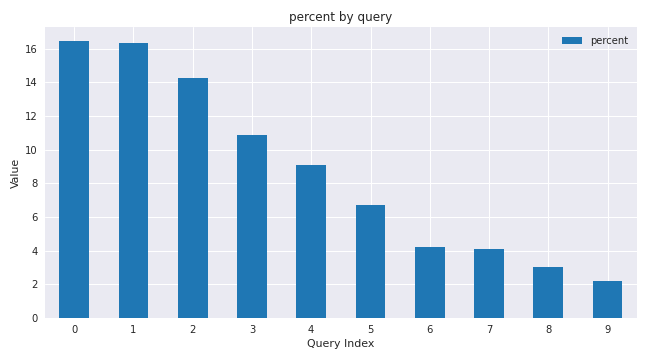

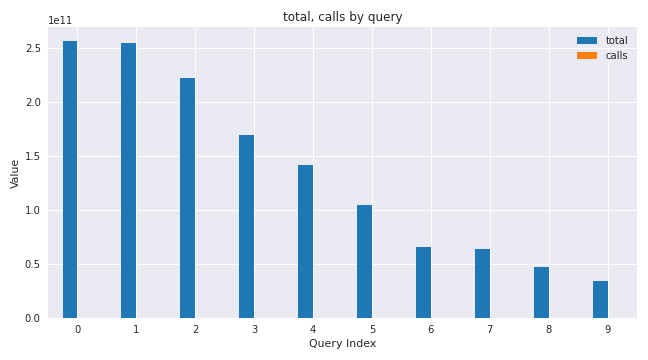

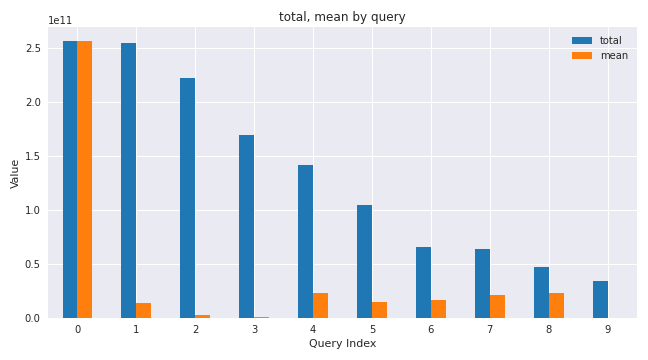

In [51]:
q("""SELECT (100 * SUM_TIMER_WAIT / sum(SUM_TIMER_WAIT) OVER ()) percent, 
        sum_timer_wait as total, 
        count_star as calls, 
        avg_timer_wait as mean,
        substring(digest_text,1,75)
FROM 
performance_schema.events_statements_summary_by_digest 
        ORDER BY sum_timer_wait DESC
        LIMIT 10;""")